In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

2023-12-02 21:34:04.561981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:

import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


/Users/sumaiyauddin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the augmented data from the saved file with allow_pickle=True
data = np.load('../data/external/Pickles/coral_augmented_yolo.npz', allow_pickle=True)

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (7568, 224, 224, 3)
y_train shape: (7568,)
X_valid shape: (1896, 224, 224, 3)
y_valid shape: (1896,)
X_test shape: (2368, 224, 224, 3)
y_test shape: (2368,)


In [7]:
import os
import cv2
import numpy as np

# Create directories if they don't exist
base_path = '/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/yolo/'
image_folder = 'images'
label_folder = 'labels'
subfolders = ['train', 'test', 'valid']

for folder in [image_folder, label_folder]:
    folder_path = os.path.join(base_path, folder)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        for subfolder in subfolders:
            subfolder_path = os.path.join(folder_path, subfolder)
            os.makedirs(subfolder_path)

# Save images and labels for each set (train, test, valid)
sets = [('train', X_train, y_train), ('test', X_test, y_test), ('valid', X_valid, y_valid)]

for set_name, X, y in sets:
    image_folder_path = os.path.join(base_path, image_folder, set_name)
    label_folder_path = os.path.join(base_path, label_folder, set_name)

    for i in range(X.shape[0]):
        # Save image
        image_path = os.path.join(image_folder_path, f'image{i + 1:02d}.jpg')
        cv2.imwrite(image_path, X[i])

        # Save label
        label_path = os.path.join(label_folder_path, f'image{i + 1:02d}.txt')

        with open(label_path, 'w') as f:
            for label in y[i]:
                f.write(' '.join(map(str, label)) + '\n')


In [4]:
# Print the first three values in labels_array
print("First values in labels_array:", y_train[201])

First values in labels_array: [[0, 0.764, 0.416, 0.112, 0.276], [0, 0.94, 0.41, 0.119, 0.136]]


In [65]:
print("Training Data - Min:", np.min(X_train), "Max:", np.max(X_train))
print("Validation Data - Min:", np.min(X_valid), "Max:", np.max(X_valid))
print("Test Data - Min:", np.min(X_test), "Max:", np.max(X_test))

Training Data - Min: 0.0 Max: 255.0
Validation Data - Min: 0.0 Max: 255.0
Test Data - Min: 0.0 Max: 255.0


In [66]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0
print("Training Data - Min:", np.min(X_train), "Max:", np.max(X_train))
print("Validation Data - Min:", np.min(X_valid), "Max:", np.max(X_valid))
print("Test Data - Min:", np.min(X_test), "Max:", np.max(X_test))

Training Data - Min: 0.0 Max: 1.0
Validation Data - Min: 0.0 Max: 1.0
Test Data - Min: 0.0 Max: 1.0


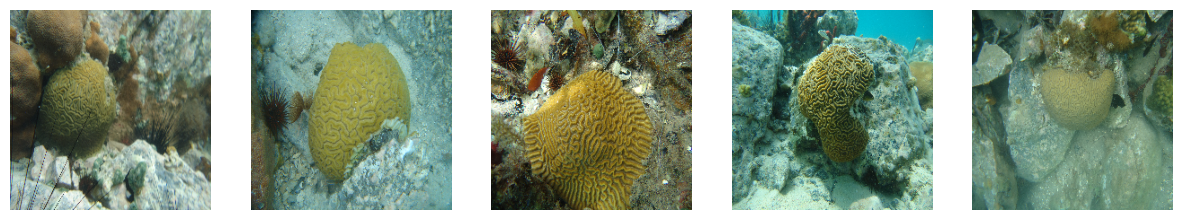

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of samples to display
num_samples_to_display = 5

# Create subplots to display the images
plt.figure(figsize=(15, 5))

for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    
    # Normalize pixel values to the range [0, 1]
    # Swap color channels to convert from BGR to RGB
    plt.imshow(np.flip(X_train[i], axis=-1))
    
    plt.axis("off")

plt.show()


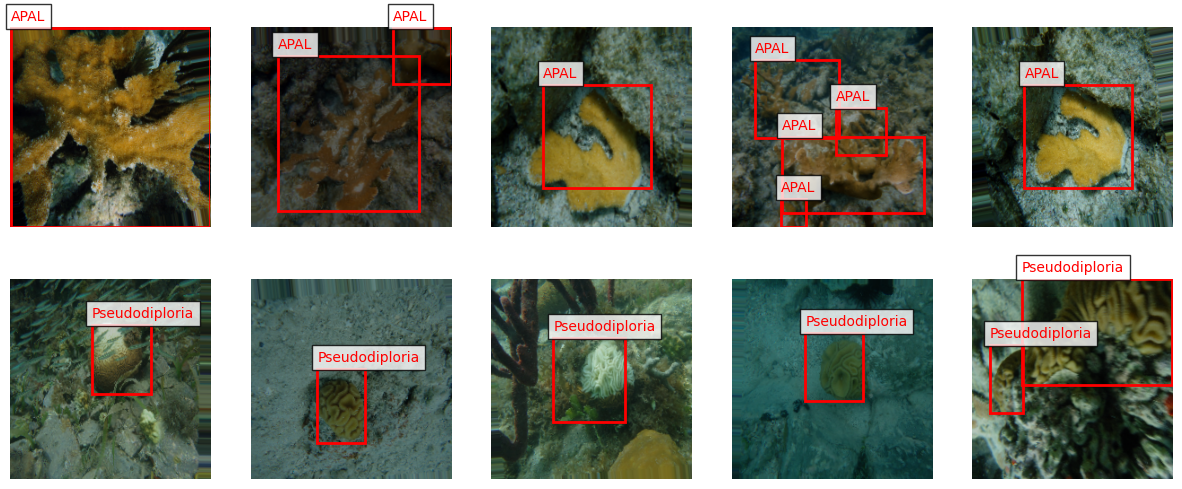

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np
from PIL import Image

resize_width, resize_height = (224, 224)
# Choose the classes to visualize
classes_to_visualize = {0: 'APAL', 1: 'Pseudodiploria'}

# Counter to keep track of displayed images for each class
displayed_images_count = {'APAL': 0, 'Pseudodiploria': 0}

# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the axs array for easier indexing
axs = axs.flatten()

# Iterate through classes to visualize
for class_label, class_name in classes_to_visualize.items():
    # Filter images with the current class
    class_images = [(X_train[i], y_train[i]) for i, labels in enumerate(y_train) if any(box[0] == class_label for box in labels)]

    # Randomly select up to 5 images for the current class
    selected_images = random.sample(class_images, min(5, len(class_images)))

    # Display the selected images
    for i, (image, labels) in enumerate(selected_images):
        # Flip the color channels if in BGR format
        image_rgb = np.flip(image, axis=-1)  # Assuming BGR format, if not, remove this line

        # Convert image array to PIL Image
        pil_image = Image.fromarray((image_rgb * 255).astype(np.uint8))

        # Display the image
        axs[class_label * 5 + i].imshow(pil_image)

        # Iterate through bounding boxes and display
        for box in labels:
            if box[0] == class_label:
                center_x, center_y, width, height = box[1:]
                x = int(center_x * resize_width)
                y = int(center_y * resize_height)
                w = int(width * resize_width)
                h = int(height * resize_height)
                x_min = max(0, x - w // 2)
                y_min = max(0, y - h // 2)

                # Display the bounding box
                bbox = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='r', facecolor='none')
                axs[class_label * 5 + i].add_patch(bbox)

                # Display the class label within the bounding box
                axs[class_label * 5 + i].text(x_min, y_min - 5, class_name, color='r', verticalalignment='bottom',
                                              bbox=dict(facecolor='white', alpha=0.8))

        # Remove axis ticks and labels
        axs[class_label * 5 + i].axis('off')

# Show the plot
plt.show()


In [69]:

def yolo_loss(y_true, y_pred):
    # Split the y_pred tensor into its components: bbox_xy, bbox_wh, obj_conf, class_prob
    bbox_xy_true, bbox_wh_true, obj_conf_true, class_prob_true = tf.split(y_true, (2, 2, 1, -1), axis=-1)
    bbox_xy_pred, bbox_wh_pred, obj_conf_pred, class_prob_pred = tf.split(y_pred, (2, 2, 1, -1), axis=-1)

    # Calculate the coordinates of the bounding boxes
    bbox_true = tf.concat([bbox_xy_true, bbox_wh_true], axis=-1)
    bbox_pred = tf.concat([bbox_xy_pred, bbox_wh_pred], axis=-1)

    # Localization loss (mean squared error)
    loc_loss = tf.reduce_sum(tf.square(bbox_true - bbox_pred), axis=-1)

    # Confidence loss (binary crossentropy)
    obj_conf_loss = tf.nn.sigmoid_cross_entropy_with_logits(obj_conf_true, obj_conf_pred)

    # Class prediction loss (categorical crossentropy)
    class_prob_loss = tf.nn.sigmoid_cross_entropy_with_logits(class_prob_true, class_prob_pred)

    # Sum up the losses
    total_loss = tf.reduce_mean(loc_loss + obj_conf_loss + class_prob_loss)

    return total_loss


In [70]:

def darknet53(x):
    # Layer 1
    x = conv_block(x, filters=32, kernel_size=3, strides=1)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Layer 2 - 5
    for i in range(1, 5):
        x = darknet_block(x, filters=2**i * 32)

    # Layer 6 - 8
    for _ in range(3):
        x = darknet_block(x, filters=512)

    return x

def darknet_block(x, filters):
    # 1x1 conv
    x = conv_block(x, filters=filters, kernel_size=1, strides=1)
    
    # 3x3 conv
    x = conv_block(x, filters=filters * 2, kernel_size=3, strides=1)

    # Residual connection
    residual = layers.Conv2D(filters * 2, kernel_size=1, strides=1, padding='same')(x)
    x = layers.Concatenate()([x, residual])

    return x

def make_yolo_head(x, num_anchors, num_classes):
    # 1x1 convolutions for channel reduction
    x = conv_block(x, filters=256, kernel_size=1, strides=1)

    # 3x3 convolution
    x = conv_block(x, filters=512, kernel_size=3, strides=1)

    # 1x1 convolutions for channel reduction
    x = conv_block(x, filters=256, kernel_size=1, strides=1)

    # 3x3 convolution
    x = conv_block(x, filters=512, kernel_size=3, strides=1)

    # 1x1 convolutions for channel reduction
    x = conv_block(x, filters=256, kernel_size=1, strides=1)

    # 3x3 convolution
    x = conv_block(x, filters=512, kernel_size=3, strides=1)

    # Final convolutional layer for predictions
    predictions = layers.Conv2D(num_anchors * (4 + 1 + num_classes), kernel_size=1, strides=1, activation='linear')(x)

    return predictions


def conv_block(x, filters, kernel_size, strides):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    return x

def create_yolo_model(input_shape, num_classes):
    input_layer = tf.keras.Input(shape=input_shape, name='input_layer')

    # Backbone (Darknet-53 in this simplified example)
    x = darknet53(input_layer)

    # Detection Head
    yolo_output = make_yolo_head(x, num_anchors=3, num_classes=num_classes)

    model = tf.keras.Model(inputs=input_layer, outputs=yolo_output, name='yolo_model')
    return model

# Example usage
input_shape = (224, 224, 3)
num_classes = 2  # Number of classes (APAL and Peosodiploria)
model = create_yolo_model(input_shape, num_classes)

model.compile(optimizer='adam', loss=yolo_loss)

# Print the model summary
model.summary()


Model: "yolo_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_116 (Conv2D)            (None, 224, 224, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 224, 224, 32  128        ['conv2d_116[0][0]']             
 ormalization)                  )                                                        

In [61]:
import tensorflow as tf
import numpy as np

# Assuming y_train is a list of YOLO labels
def convert_to_ragged(labels):
    values = [item for sublist in labels for item in sublist]
    row_splits = [len(sublist) for sublist in labels]
    return tf.RaggedTensor.from_row_splits(values, row_splits)

# Print the lengths of sublists in y_train
print("Lengths of sublists in y_train:", [len(sublist) for sublist in y_train])

# Try to convert to tf.RaggedTensor
y_train_tf = convert_to_ragged(y_train)


Lengths of sublists in y_train: [1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 4, 1, 1, 2, 1, 1, 1, 1, 13, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 2, 1, 3, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 8, 1, 1, 1, 1, 2, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 2, 3, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 13, 3, 1, 3, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 13, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 12, 1, 1, 1, 1, 2, 4, 1, 3, 1, 1, 4, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 8, 3, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 4, 3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 2, 2, 4, 1, 3, 1, 1, 1, 3, 1, 1, 1, 

InvalidArgumentError: Arguments to from_row_splits do not form a valid RaggedTensor:zero
Condition x == y did not hold.
First 1 elements of x:
[1]
First 1 elements of y:
[0]

In [54]:
print("X_train shape:", X_train.shape)
print("y_train_tf shape:", y_train_tf.shape)


X_train shape: (7568, 224, 224, 3)
y_train_tf shape: (11632, 5)


In [50]:
# Print the first three values in labels_array
print("First values in labels_array:", y_train[201])

First values in labels_array: [[0.    0.764 0.416 0.112 0.276]
 [0.    0.94  0.41  0.119 0.136]]


In [71]:
# Now you can use yolo_train_labels and yolo_valid_labels in the fit method
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [24]:
model.save('../models/coral_yolo.h5')

NameError: name 'model' is not defined

In [ ]:
# Assuming you have already trained your model and have the `history` object
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 5)

# Extract training and validation accuracy from the history object
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation accuracy with purple markers and solid line
ax[0].plot(epochs, train_acc, 'p-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'm-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Extract training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss with purple markers and solid line
ax[1].plot(epochs, train_loss, 'p-', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()
